In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl
import cbmos.utils as ut

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 7.5  # final time
rA = 1.5   # maximum interaction distance
dim = 3
seed=67

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

# Global adaptive time-stepping for a globally compressed monolayer

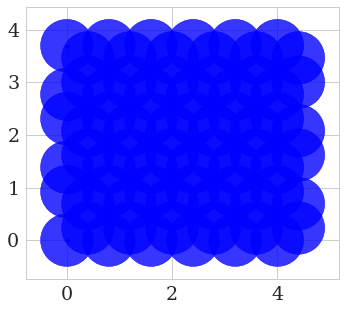

In [10]:
coords = ut.generate_hcp_coordinates(6,6,6, scaling=0.8)

sheet = [cl.Cell(i, [x,y,z]) for i, (x,y,z) in enumerate(coords)]

ut.plot_2d_population(sheet)

Initial step cubic 0.08004295147967337
Stability bound estimate cubic 0.1615021491814414
Initial step cubic 0.0357962961256534
Stability bound estimate cubic 0.12745811701358367
Initial step cubic 0.016008590295934672
Stability bound estimate cubic 0.12932985007063516
Initial step cubic 0.035638729191715124
Stability bound estimate cubic 0.05371102788151523
Initial step cubic 0.035638729191715124
Stability bound estimate cubic 0.05371102788151523
Initial step cubic 0.016005565400421064
Stability bound estimate cubic 0.04443898587420993


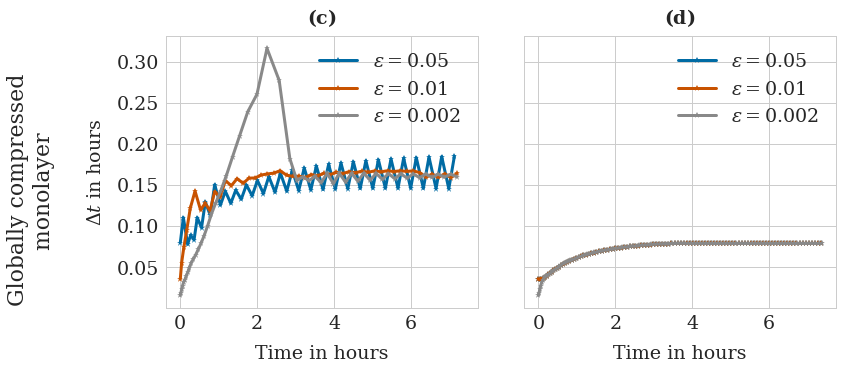

In [11]:
colors = [defcolors[0], defcolors[5], defcolors[6]]
# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

#ax1 No Jacobian - accuracy bound only
#ax1.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2])
#ax1.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax1.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

force = 'cubic'
epsilons = [0.05, 0.01, 0.002]

for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    ax1.plot(ts[:-2], dts[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i])




ax1.legend()
ax1.set_title(r'$\bf{(c)}$')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t$ in hours')
#ax1.set(ylim=[-0.01, 0.29])
ax1.text(-4.5, 0.01, 'Globally compressed\n        monolayer', fontsize=22, rotation='vertical')
#ax1.text(3.7, 1.45, '$\epsilon=0.01$', fontsize=22)

#ax2 Using the Jacobian to obtain the stability bound
#ax2.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2])
#ax2.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax2.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )


for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax2.plot(ts[:-2], dts[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i])

ax2.set_title(r'$\bf{(d)}$')
ax2.legend()
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t$ in hours')
#ax2.set(ylim=[-0.1, 1.2])
#ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

plt.savefig('global_adap_glob_mono.pdf', bbox_inches='tight')

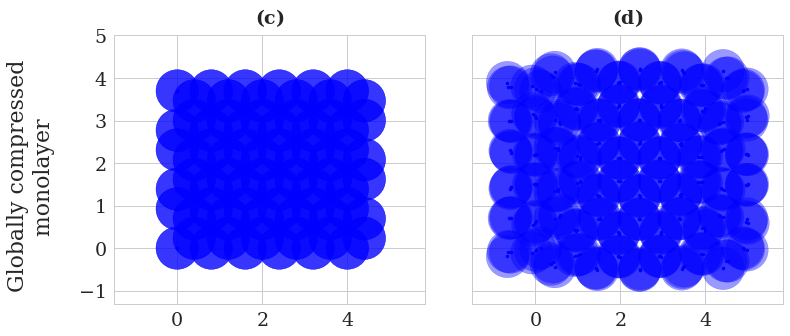

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

n_cells = len(sheet)
for i in range(n_cells):
    #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
    ax1.add_patch(plt.Circle(sheet[i].position ,0.5,color='blue', alpha=0.4))
    ax1.plot(sheet[i].position[0], sheet[i].position[1], '.', color='blue')
    ax1.set_aspect('equal')
ax1.text(-4.0, -0.9, 'Globally compressed\n        monolayer', fontsize=22, rotation='vertical')
ax1.set_title(r'$\bf{(c)}$')


n_cells = len(history[-1])
for i in range(n_cells):
    #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
    ax2.add_patch(plt.Circle(history[-1][i].position ,0.5,color='blue', alpha=0.4))
    ax2.plot(history[-1][i].position[0], history[-1][i].position[1], '.', color='blue')
    ax2.set_aspect('equal')
ax2.set_title(r'$\bf{(d)}$')

    
plt.savefig('global_mono_plot.pdf', bbox_inches='tight')

# Dependence of initial step and stability bound on number of neigbors

In [11]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
stability_bounds = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sl = [2, 3, 4, 5, 8, 10, 15]
for l in sl:
    sheet = make_compressed_sheet(l)
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        sbe = (dts[-2]+dts[-1])/2.0
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])
        stability_bounds[force].append(sbe)
        


In [12]:
n_cells = [(2*l-1)*(l+(l-1)//2+l//2) for l in sl]
for force in force_names:
    plt.plot(n_cells, stability_bounds[force], '-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_s$ in hours')
#plt.savefig('dependence_stability_n_cells.pdf', bbox_inches='tight')

TypeError: list indices must be integers or slices, not str

In [ ]:
for force in force_names:
    plt.plot(n_cells, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')
plt.savefig('dependence_initial_step_n_cells.pdf', bbox_inches='tight')

# Plotting $\eta_k$ for a larger sheet

In [ ]:
sheet = make_compressed_sheet(4)

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')   
    try:
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file' : True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
#    print('Initial step '+force + ' ' +str(dts[0]))
#    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
#    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.savefig('adaptivity_38cells.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_38cells.png', bbox_inches='tight')

In [ ]:
AFs = np.loadtxt('AFs'+filename_ending['pw. quad.']+'.txt')
sorted_AFs = np.sort(AFs)


In [ ]:
plt.plot(sorted_AFs[0,::-1], label='$t=\Delta t_0$')
plt.plot(sorted_AFs[1,::-1], label='$t=\Delta t_0+\Delta t_1$')
plt.plot(sorted_AFs[2,::-1], label='$t=\Delta t_0+\Delta t_1+\Delta t_2$')

plt.plot(sorted_AFs[-1,::-1], label='$t=t_f$')
plt.xlabel('k')
plt.ylabel('$|\eta_k|$, sorted decreasingly')
plt.legend()
plt.savefig('eta_k_pwq.pdf', bbox_inches='tight')